# Baseline

In [1]:
import gc
import gzip

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, dot, Flatten, Input, Lambda, LSTM, Permute, \
                         RepeatVector, TimeDistributed, Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt

import re
import tensorflow as tf

tf.enable_eager_execution()

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
## Login using diego.molla-aliod@mq.edu.au

In [3]:
#!ls /content/gdrive/'My Drive'

In [4]:
GIGAWORD_FILE = 'data/gigawordeng/cut_downweek11.csv'
# GIGAWORD_FILE = '/content/gdrive/My Drive/COMP388Ollie/data/gigawordeng/cut_downweek11.csv'
# GIGAWORD_FILE = '/content/gdrive/My Drive/COMP388Ollie/data/gigawordeng/abridged.csv')

In [5]:
%%time
NUM_WORDS = 20000

VAL_SIZE = 5000

STEPS = 15

df = pd.read_csv(GIGAWORD_FILE)
df = df.drop(['Unnamed: 0'], axis=1)
df.columns = ['headline', 'story']

tokenizer = Tokenizer(num_words=NUM_WORDS)
df = df.applymap(lambda x : x.replace('\t', '00 ').replace('\r\r\n', ' 99'))

val_df = df[-VAL_SIZE:]
df = df[:-VAL_SIZE]

tokenizer.fit_on_texts(df['story'])
tokenizer_words = tokenizer.word_index
index_word_map = dict(map(reversed, tokenizer.word_index.items()))

seqlen_X = min(80, max([len(text.split()) for text in df['story']]))
seqlen_y = min(20, max([len(text.split()) for text in df['headline']]))

CPU times: user 822 ms, sys: 35.7 ms, total: 858 ms
Wall time: 857 ms


(array([  75.,   99.,  399.,  916., 2671., 5076., 5950., 3366.,  715.,
          44.]),
 array([ 3., 12., 21., 30., 39., 48., 57., 66., 75., 84., 93.]),
 <a list of 10 Patch objects>)

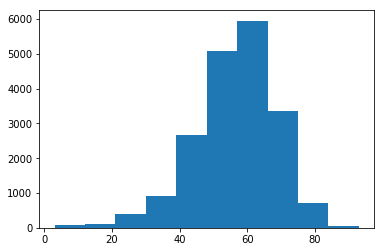

In [6]:
lengths = [len(text.split()) for text in df['story']]
plt.hist(lengths)

(array([ 763., 1718., 4211., 2903., 5445., 2865.,  690.,  587.,  116.,
          13.]),
 array([ 3. ,  4.7,  6.4,  8.1,  9.8, 11.5, 13.2, 14.9, 16.6, 18.3, 20. ]),
 <a list of 10 Patch objects>)

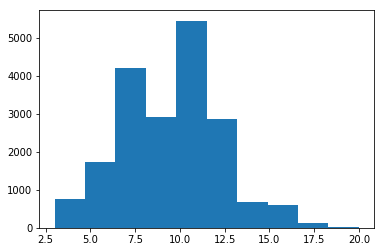

In [7]:
lengths = [min(20,len(text.split())) for text in df['headline']]
plt.hist(lengths)

In [8]:
print('Number of stories:', len(df) )
print('Number of unique input words:', len(tokenizer_words))
print('Max sequence length for inputs:', seqlen_X)
print('Max sequence length for outputs:', seqlen_y)

Number of stories: 19311
Number of unique input words: 36962
Max sequence length for inputs: 80
Max sequence length for outputs: 20


In [9]:
def encode_data(data, seqlen, shift_num=0, one_hot=True, reverse=True):
    data = tokenizer.texts_to_sequences(data)
    if reverse:
      data = [x[:seqlen:-1] for x in data]
    else:
      data = [x[:seqlen] for x in data]

      padded = pad_sequences(data, maxlen=seqlen, padding='post')
    del data
    
    if shift_num != 0:
        padded = shift(padded, shift_num)
    if one_hot:    
        padded = to_categorical(padded, NUM_WORDS+1).astype('bool')
    else:
        padded = padded.astype('int32')
    return padded   

def shift(arr, num, fill_value=0):
    result = []
    for r in arr:
      rr = np.empty_like(r)
      if num > 0:
          rr[:num] = fill_value
          rr[num:] = r[:-num]
      elif num < 0:
          rr[num:] = fill_value
          rr[:num] = r[-num:]
      else:
          rr = arr
      result.append(rr)
    return np.array(result) 
  
#def shiftBK(arr, num, fill_value=0):
#    result = np.empty_like(arr)
#    if num > 0:
#        result[:num] = fill_value
#        result[num:] = arr[:-num]
#    elif num < 0:
#        result[num:] = fill_value
#        result[:num] = arr[-num:]
#    else:
#        result = arr
#    return result 

In [10]:
print(df['story'][:10])
for row in encode_data(df['story'][:10], seqlen_X, one_hot=False, reverse=False):
  #print(row)
  #continue
  for c in row:
    if c == 0:
      print("_", end='')
    else:
      print(index_word_map[c], " ", end='')
  print()

0    Tributes poured in from around the world Thurs...
1    France would not join a US military invasion o...
2    The Azerbaijani enclave of Nagorno Karabakh wa...
3    This time, Nigel Mansell will not be left behi...
4    Iraqi Vice Prime Minister Terek Aziz lobbied U...
5    Two RAF Hercules transport planes airlifted 14...
6    Ernie Els was back to his best when the Spanis...
7    French Foreign Minister Alain Juppe said Thurs...
8    Two RAF Hercules transport planes airlifted 14...
9    Forty young far-rightwingers armed with knives...
Name: story, dtype: object
tributes  poured  in  from  around  the  world  thursday  to  the  late  labour  party  leader  john  smith  who  died  earlier  from  a  massive  heart  attack  aged  55  in  washington  the  us  state  department  issued  a  statement  regretting  the  death  of  the  tongued  scottish  and  parliamentarian  ____________________________________
france  would  not  join  a  us  military  invasion  of  haiti  as  part  

In [11]:
print(df['headline'][:10])
for row in encode_data(df['headline'][:10], seqlen_y, one_hot=False, reverse=False, shift_num=-2):
  #print(row)
  #continue
  for c in row:
    if c == 0:
      print("_", end='')
    else:
      print(index_word_map[c], " ", end='')
  print()

0    00 Tributes pour in for late British Labour Pa...
1    00 France rules out participation in military ...
2    00 Nagorno Karabakh hit by further clashes ami...
3         00 This restart looks good by Jim Slater  99
4              00 Aziz lobbies against oil embargo  99
5    00 RAF planes airlift evacuees out of Sanaa by...
6           00 South African shoots ahead in Spain  99
7    00 US Senate vote on Bonsia "internal" matter ...
8    00 (repetition) RAF planes airlift evacuees ou...
9    00 Rightwing extremists chase Turkish group, i...
Name: headline, dtype: object
pour  in  for  late  british  labour  party  leader  99  ___________
rules  out  participation  in  military  invasion  of  haiti  99  ___________
karabakh  hit  by  further  clashes  amid  ceasefire  reports  99  ___________
restart  looks  good  by  jim  99  ______________
against  oil  embargo  99  ________________
planes  airlift  evacuees  out  of  sanaa  by  peter  99  ___________
african  ahead  in  spain  99 

In [12]:
# Make the data generator threadsafe - from https://github.com/keras-team/keras/issues/1638
import threading
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self
      
    def __next__(self):
      with self.lock:
        return next(self.it)

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

In [13]:
%%time
glove_vect = {}
GLOVE_DIM = 200 #50
GLOVE_PATH = 'data/word2vec'
#GLOVE_PATH = '/content/gdrive/My Drive/COMP388Ollie/data/word2vec'
with open(GLOVE_PATH + '/glove.6B.{0!s}d.txt'.format(GLOVE_DIM), encoding='utf-8') as file:
    for line in file:
        row = line.split()
        word = row[0]
        coefs = np.array(row[1:])
        glove_vect[word] = coefs
print(len(glove_vect))

400000
CPU times: user 9.78 s, sys: 712 ms, total: 10.5 s
Wall time: 10.5 s


In [14]:
%%time
embed_mat = np.zeros((NUM_WORDS+1, GLOVE_DIM))

for i, word in enumerate(tokenizer_words):
    if i >= NUM_WORDS:
        break
    word_clean = re.sub('\W', '', word)
    try:
        embed_vect = glove_vect[word_clean]
    except KeyError as KE: 
        embed_vect = np.random.normal(size=GLOVE_DIM)
    finally:
        embed_mat[tokenizer_words[word]] = embed_vect

CPU times: user 1.24 s, sys: 7.96 ms, total: 1.25 s
Wall time: 1.25 s


In [15]:
#!mkdir models

The following code is based on https://github.com/tensorflow/tensorflow/blob/r1.11/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb

In [16]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embed_mat], trainable=True)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embed_mat], trainable=True)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        print(output.shape)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [19]:
EMBED_DIM = 200
NUM_HID_NODES = 400
BATCH_SIZE = 32 # 256
encoder = Encoder(NUM_WORDS+1, EMBED_DIM, NUM_HID_NODES, BATCH_SIZE)
decoder = Decoder(NUM_WORDS+1, EMBED_DIM, NUM_HID_NODES, BATCH_SIZE)

In [20]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [21]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [22]:
import random
@threadsafe_generator # From https://github.com/keras-team/keras/issues/1638
def batch_generator(X, y, batch_size, shuffle=True):
    if shuffle:
      indices = list(range(len(X)))
      random.shuffle(indices)
      
    counter = 0 
    while True:
        batch_start = counter * batch_size
        if shuffle:
            X_tmp = X[indices[batch_start:batch_start+batch_size]]
            y_tmp = y[indices[batch_start:batch_start+batch_size]]
        else:
            X_tmp = X[batch_start:batch_start+batch_size]
            y_tmp = y[batch_start:batch_start+batch_size]
          
        
        counter += 1
        #if debug and counter >= 10:
        #  return
        
        if len(X_tmp) < batch_size:
          return
        
        #if len(X_tmp) == 0:
        #    counter = 0
        #    batch_start = counter * batch_size 
        #    X_tmp = X[batch_start:batch_start+batch_size]
        #    y_tmp = y[batch_start:batch_start+batch_size]

        
        preprocessed = {}
        preprocessed['enc_X'] = encode_data(X_tmp, seqlen_X, one_hot=False, reverse=False)
        preprocessed['dec_X'] = encode_data(y_tmp, seqlen_y, one_hot=False, reverse=False)
        preprocessed['dec_y'] = encode_data(y_tmp, seqlen_y, reverse=False, shift_num=-1, one_hot=False)
        yield (
            [
                preprocessed['enc_X'],
                preprocessed['dec_X'],
            ],
            preprocessed['dec_y']
        )

In [23]:
## Checking that the batches generated are correct
#bg = batch_generator(df['story'], df['headline'], 1000) #, shuffle=False)
#for i in range(int(len(df)*1.5/1000)):
#  d = next(bg)
#  print(len(d[0]), len(d[1]))
#  print(d[0][0], d[0][1], d[1])

In [24]:
#bg = batch_generator(val_df['story'], val_df['headline'], 900)
#for i in range(int(len(df)*1.5/900)):
#  d = next(bg)
#  print(len(d[0]), len(d[1]))

In [25]:
import time
import sys
#from tqdm import tqdm

EPOCHS = 20
patience = 2

last_val_loss = 0
i_patience = 0
for epoch in range(EPOCHS):
    start = time.time()
    
    train_gen = batch_generator(df['story'], df['headline'], BATCH_SIZE, shuffle=True)
    
    hidden = encoder.initialize_hidden_state()
    all_losses = []
    
    N_BATCH = len(df)//BATCH_SIZE
    N_VAL_BATCH = len(val_df)//BATCH_SIZE
    
    old_decile = 0
    for (batch, ((inp_encoder, inp_decoder), targ)) in enumerate(train_gen):
    #for (batch, ((inp_encoder, inp_decoder), targ)) in tqdm(enumerate(train_gen),
    #                                                       total=N_BATCH):
        inp_encoder = tf.convert_to_tensor(inp_encoder, np.float32)
        inp_decoder = tf.convert_to_tensor(inp_decoder, np.float32)
        inp_decoder = tf.expand_dims(inp_decoder, 1)
        #print("Batch", batch)
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp_encoder, hidden)
            
            dec_hidden = enc_hidden
            
            
            # Teacher forcing - feeding the target as the next input
            for t in range(inp_decoder.shape[2]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(inp_decoder[:,:,t], dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        #total_loss += batch_loss
        all_losses.append(batch_loss)
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        #centile = batch*100/N_BATCH
        #bar = "["+"="*int(centile/10)+" "*(10-int(centile/10))+"]"
        #print("%3i %s %i%% Batch %i\r" % (epoch, bar, centile, batch), end='')       
        #sys.stdout.flush()

        #print("%3i %s %i%% Batch %i" % (epoch, bar, centile, batch))       

        decile = batch*10//N_BATCH
        if batch == 0 or decile > old_decile:
        #if batch % 100 == 0:
            old_decile = decile
            print('Epoch {} Batch {} Loss {:.4f} {}0%'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy(),
                                                         decile))
            #if decile >= 2:
            #  break
            
    #bar = "["+"="*10+"]"
    #print("%3i %s 100%%" % (epoch, bar))
      
    # Validation data
    val_gen = batch_generator(val_df['story'], val_df['headline'], BATCH_SIZE, shuffle=False)
    all_val_losses = []
    for (batch, ((inp_encoder, inp_decoder), targ)) in enumerate(val_gen):
        inp_encoder = tf.convert_to_tensor(inp_encoder, np.float32)
        inp_decoder = tf.convert_to_tensor(inp_decoder, np.float32)
        inp_decoder = tf.expand_dims(inp_decoder, 1)
        #print("Batch", batch)
        loss = 0
        enc_output, enc_hidden = encoder(inp_encoder, hidden)
        dec_hidden = enc_hidden
        for t in range(inp_decoder.shape[2]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(inp_decoder[:,:,t], dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
        batch_loss = (loss / int(targ.shape[1]))
        #total_val_loss += batch_loss
        all_val_losses.append(batch_loss)
    
#    print('Epoch {} Loss {:.4f} Val Loss {:.4f}'.format(epoch + 1,
#                                                        total_loss / N_BATCH,
#                                                        total_val_loss / N_VAL_BATCH))
    print('Epoch {} Loss {:.4f} Val Loss {:.4f}'.format(epoch + 1,
                                                        np.mean(all_losses),
                                                        np.mean(all_val_losses)))
    
    print('Time taken for 1 epoch {} sec'.format(time.time() - start))
    
    # saving (checkpoint) if validation loss improves
    total_val_loss = np.mean(all_val_losses)
    if epoch == 0 or total_val_loss < last_val_loss:
#    if (epoch + 1) % 2 == 0:
        print("Saving checkpoint")
        checkpoint.save(file_prefix = checkpoint_prefix)
        last_val_loss = total_val_loss
        i_patience = 0
    else:
        i_patience += 1
        if i_patience > patience:
            print("Ran out of patience")
            break
    print()

Epoch 1 Batch 0 Loss 4.6423 00%
Epoch 1 Batch 61 Loss 3.2059 10%
Epoch 1 Batch 121 Loss 2.6442 20%
Epoch 1 Batch 181 Loss 3.0764 30%
Epoch 1 Batch 242 Loss 2.7573 40%
Epoch 1 Batch 302 Loss 2.7570 50%
Epoch 1 Batch 362 Loss 2.7655 60%
Epoch 1 Batch 423 Loss 2.6163 70%
Epoch 1 Batch 483 Loss 2.7877 80%
Epoch 1 Batch 543 Loss 2.7561 90%
Epoch 1 Loss 2.8699 Val Loss 2.7805
Time taken for 1 epoch 287.38137125968933 sec
Saving checkpoint

Epoch 2 Batch 0 Loss 2.5248 00%
Epoch 2 Batch 61 Loss 2.7033 10%
Epoch 2 Batch 121 Loss 2.6094 20%
Epoch 2 Batch 181 Loss 2.7049 30%
Epoch 2 Batch 242 Loss 2.5566 40%
Epoch 2 Batch 302 Loss 2.5517 50%
Epoch 2 Batch 362 Loss 2.7114 60%
Epoch 2 Batch 423 Loss 2.6664 70%
Epoch 2 Batch 483 Loss 2.7378 80%
Epoch 2 Batch 543 Loss 2.6787 90%
Epoch 2 Loss 2.6582 Val Loss 2.6841
Time taken for 1 epoch 287.140508890152 sec
Saving checkpoint

Epoch 3 Batch 0 Loss 2.4456 00%
Epoch 3 Batch 61 Loss 2.3176 10%
Epoch 3 Batch 121 Loss 2.5129 20%
Epoch 3 Batch 181 Loss 2.73

In [26]:
def evaluate(input_text, encoder, decoder):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=seqlen_X, padding='post')
    attention_plot = np.zeros((seqlen_y, seqlen_X))

    inputs = tf.convert_to_tensor(input_seq)
    
    result = ''

    hidden = [tf.zeros((1, NUM_HID_NODES))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer_words['00']], 0)
    #dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(seqlen_y):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        #predicted_id = tf.multinomial(predictions, num_samples=1)[0][0].numpy()
        predicted_id = tf.argmax(predictions, axis=1)[0].numpy()

        #result += targ_lang.idx2word[predicted_id] + ' '
        result += index_word_map[predicted_id] + ' '

        #if targ_lang.idx2word[predicted_id] == '<end>':
        if index_word_map[predicted_id] == '99':
            return result, input_text, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, input_text, attention_plot

In [27]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    #print("Sentence:", [''] + sentence)
    plt.xticks(np.arange(len(sentence)))
    plt.yticks(np.arange(len(predicted_sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [28]:
def headline(sentence, encoder, decoder):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder)
        
    #print('Input: {}'.format(sentence.split(' ')))
    #print('Predicted headline: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    #print(attention_plot.shape)
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    return result

In [29]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
#checkpoint.restore('training_checkpoints/ckpt-4')

Japan will send its top trade negotiators to the United States as early as next week in a bid to break the impasse in stalled talks, International Trade and Industry Minister Eijiro Hata said Friday.  The announcement followed reports that the United States had softened its tough stance in the talks, which collapsed in February.
00 Japan to send officials to US to break impasse over trade  99
GENERATED: 


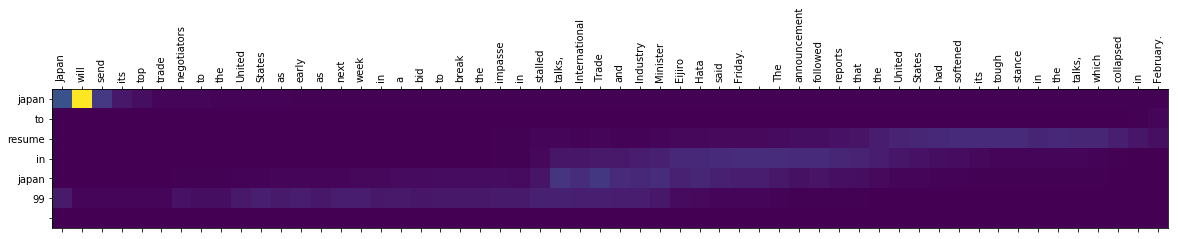

japan to resume in japan 99 


In [30]:
print(df['story'][100])
print(df['headline'][100])
print('GENERATED: ')
print(headline(df['story'][100], encoder, decoder))

Japan will send its top trade negotiators to the United States as early as next week in a bid to break the impasse in stalled talks, International Trade and Industry Minister Eijiro Hata said Friday.  The announcement followed reports that the United States had softened its tough stance in the talks, which collapsed in February.
00 Japan to send officials to US to break impasse over trade  99
GENERATED: 


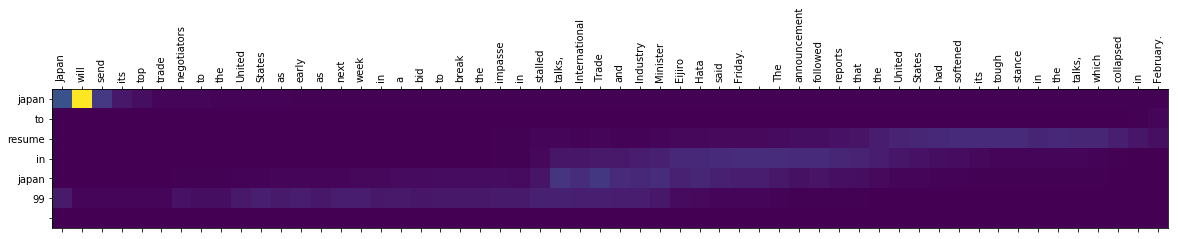

	 japan to resume in japan 99 
Two Indian Air Force Ilyushin transport planes flew home 381 Indian citizens Friday from strife-torn Yemen, the Press Trust of India (PTI) reported.  The planes landed in Bombay, the news agency said.
00 Indian air force planes bring back 381 citizens from Yemen  99
GENERATED: 


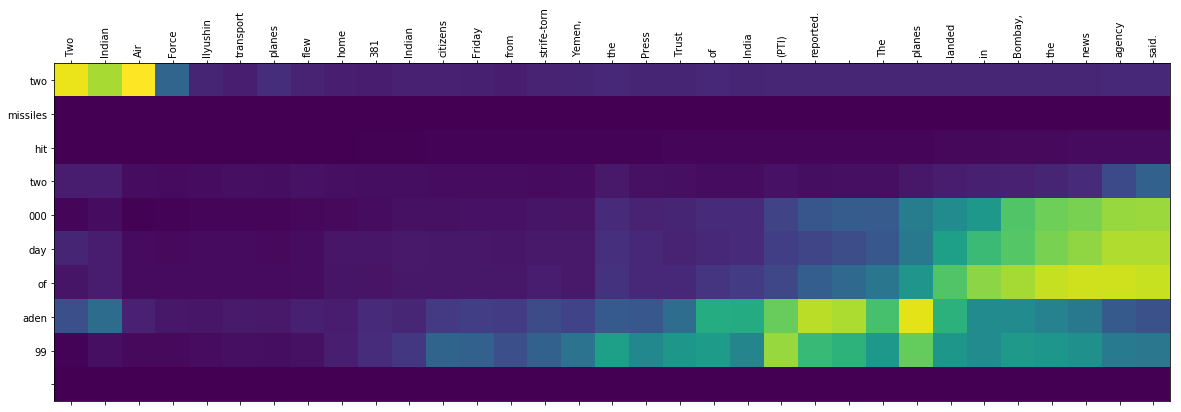

	 two missiles hit two 000 day of aden 99 
The United States needs to start behaving like a superpower by showing commitment to friendly nations and respect for their laws, a Singapore newspaper said Friday.  The Straits Times, referring to the caning here of American teenager Michael Fay for vandalising cars, said that there was still "too much rancour" in America's management of "fallout" from the row triggered by the affair.
00 Behave like superpower, US told  99
GENERATED: 


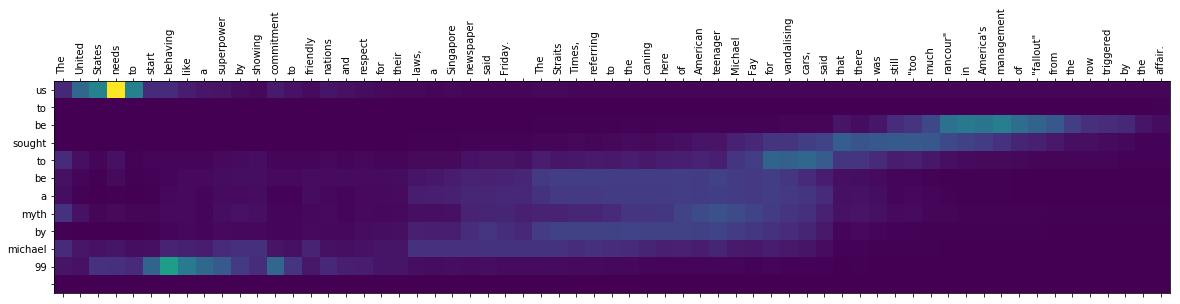

	 us to be sought to be a myth by michael 99 
Ernesto Zedillo, of the ruling Institutional Revolutionary Party (PRI), came under fire from his two main rivals late Thursday, in Mexico's first-ever televised debate of presidential candidates.  During 90 minutes, millions of Mexicans watched the three leading contenders in the August 21 elections: Zedillo, Cuahtemoc Cardenas of the leftist Revolutionary Democratic Party (PRD) and Diego Fernandez of the conservative National Action Party (PAN).
00 Zedillo under fire in Mexico's first presidential-candidate debate by Noel Lorthiois  99
GENERATED: 


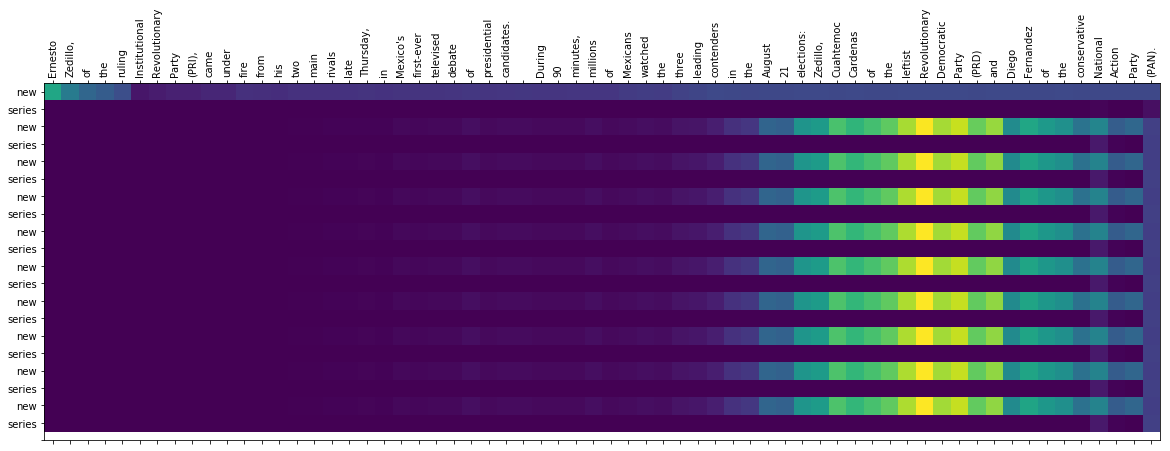

	 new series new series new series new series new series new series new series new series new series new series 
Defying protests from Thailand, Australia and five other countries are considering new military aid for Cambodia following a plea by King Norodom Sihanouk to save Cambodia "from the yoke" of the Khmer Rouge, officials said Friday.  Talks have been launched between Australia, France, the United States and some Asian countries about bolstering Cambodia's ill-disciplined, often unpaid and poorly equipped military, and a decision on aid could be made by June, they said.
00 Six countries consider military aid to counter Khmer offensive by Jack Taylor  99
GENERATED: 


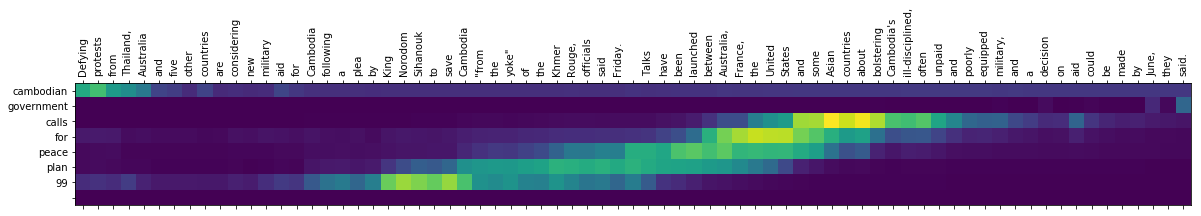

	 cambodian government calls for peace plan 99 
Australia's teddy-bear like marsupial, the koala, could become extinct because of the frequency of bush fires and housing developments, the Australian Koala Foundation said Friday.  The foundation, which has been monitoring the effects of the devastating January bush fires on koala habitats along the New South Wales coast, warned their numbers had been severely depleted.
00 Koalas becoming endangered species, experts warn  99
GENERATED: 


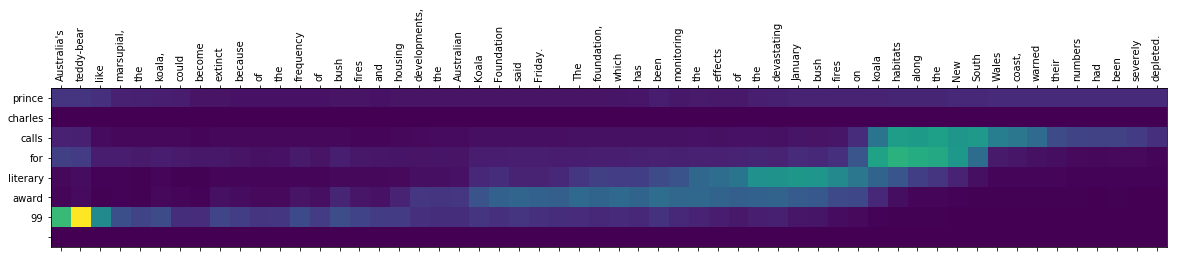

	 prince charles calls for literary award 99 
The Palestinian police were in control of the southern Gaza Strip on Friday as about 300 more reinforcements arrived and the Israelis pulled out of their last bastion.  "Everything south of the river is in the hands of the Palestinian police," a senior Israeli military official said.
00 (repetition) Southern Gaza in Palestinian police hands  99
GENERATED: 


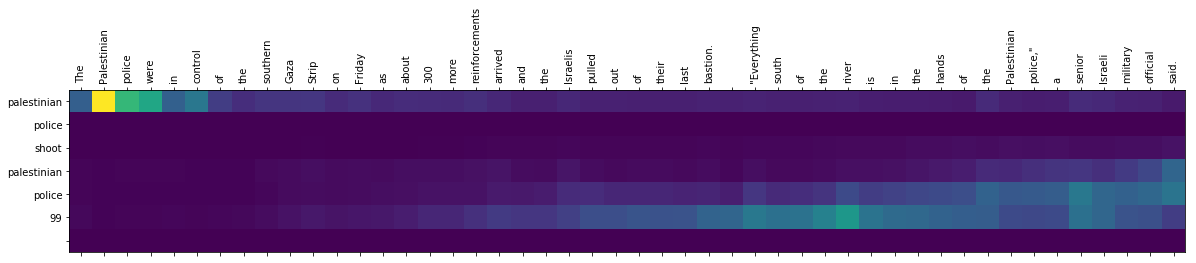

	 palestinian police shoot palestinian police 99 


In [31]:
for i in range(100,120,3):
    print(df['story'][i])
    print(df['headline'][i])
    print('GENERATED: ')
    print('\t', headline(df['story'][i], encoder, decoder))
    print('='*10)

Burma's leading dissident, Aung San Suu Kyi, begins a sixth year of house arrest in Rangoon on Wednesday, amid signs from the ruling junta that it may be her last.  A living symbol of resistance to the military regime, the Nobel Peace Laureate and daughter of Burma's independence hero Aung San, has kept world attention focused on human rights in her country.
00 Burmese dissident begins sixth year of house arrest by Jim Hatton  99
GENERATED: 


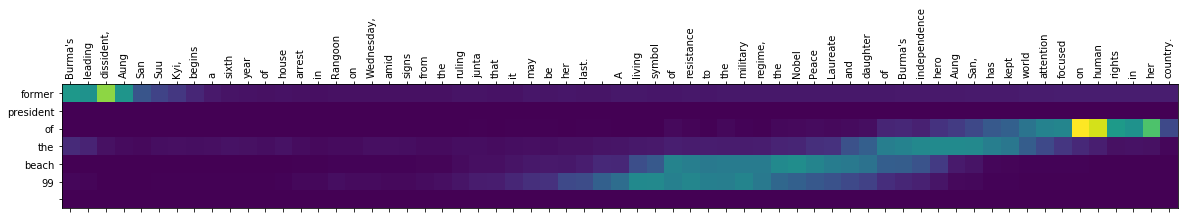

	 former president of the beach 99 
Palestinians shut out of Israel share more than just problems arising from unemployment, they also see an Israeli "conspiracy" to create a rift within the newly-autonomous Palestinian areas.  This feeling grew sharply after workers clashed Sunday with the Israeli army at the Erez crossing point. Two Palestinians were killed and 75 Palesztinians and 24 Israelis wounded, and Israel declared Gaza sealed off until further notice.
00 Workers see Israeli conspiracy in riots by Nejla Sammakia  99
GENERATED: 


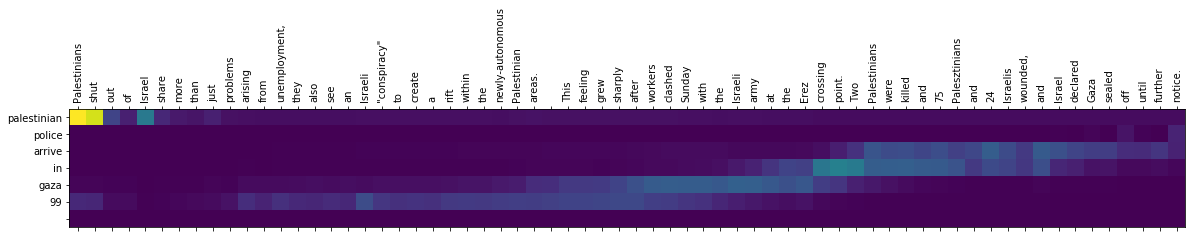

	 palestinian police arrive in gaza 99 
Israeli and Jordanian negotiators agreed Tuesday to pursue their historic negotiations for a peace treaty next month amid confident predictions of sealing a treaty.  "Israelis and Jordanians will meet again on August 8, in principle here at Ein Evrona," said Israeli defence ministry official Victor Bar Gil as the two-day first session in the desert north of the Red Sea drew to a close.
00 (pictures) Israel and Jordan agree to pursue peace talks in August by Charly Wegman  99
GENERATED: 


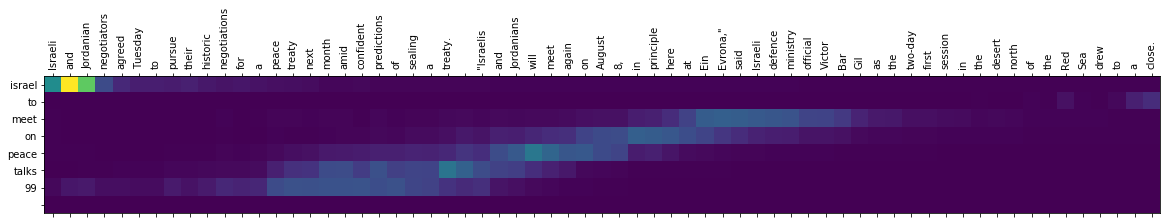

	 israel to meet on peace talks 99 
Rwanda's new government, named by rebels who now control most of the country, was sworn in Tuesday in the Rwandan capital Kigali, the rebel Rwandan Patriotic Front (RPF) radio monitored here reported.  Pasteur Bizimungu was sworn in as president and Faustin Twagiramungu as the country's prime minister, according to the radio which carried a live broadcast of the ceremony in the national parliament building.
00 New Rwandan government sworn in  99
GENERATED: 


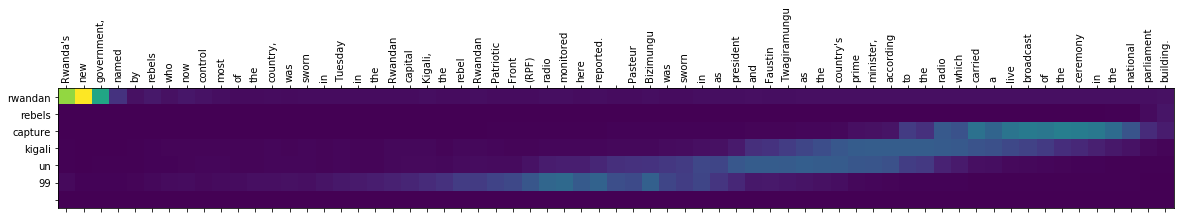

	 rwandan rebels capture kigali un 99 
Canada recorded its first monthly trade deficit in May -- 316 million dollars (227.5 million US) -- since November 1991, the government reported Tuesday.  In April, the trade surplus was 1.2 million dollars (864 million US).
00 Canada records firest trade deficit (316 million dollars) since 1991  99
GENERATED: 


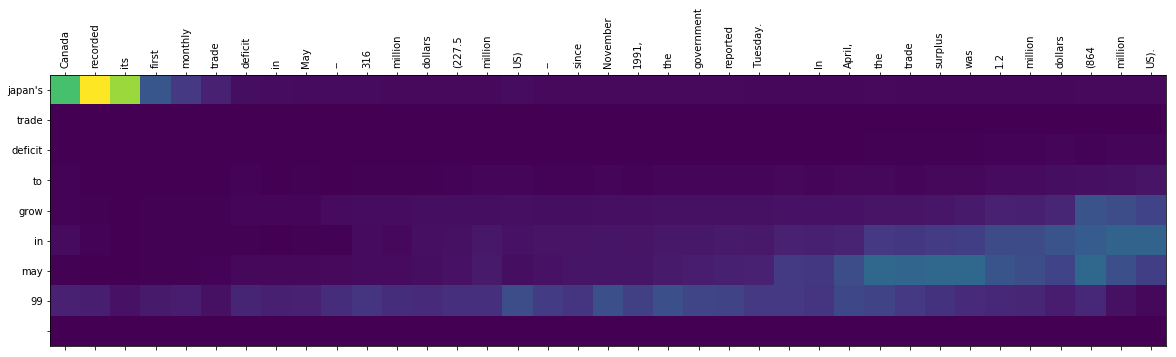

	 japan's trade deficit to grow in may 99 
Canada recorded its first monthly trade deficit in May -- 316 million dollars (227.5 million US) -- since November 1991, the government reported Tuesday.  In April, the trade surplus was 1.2 million dollars (864 million US).
00 Canada records firest trade deficit (316 million dollars) since 1991  99
GENERATED: 


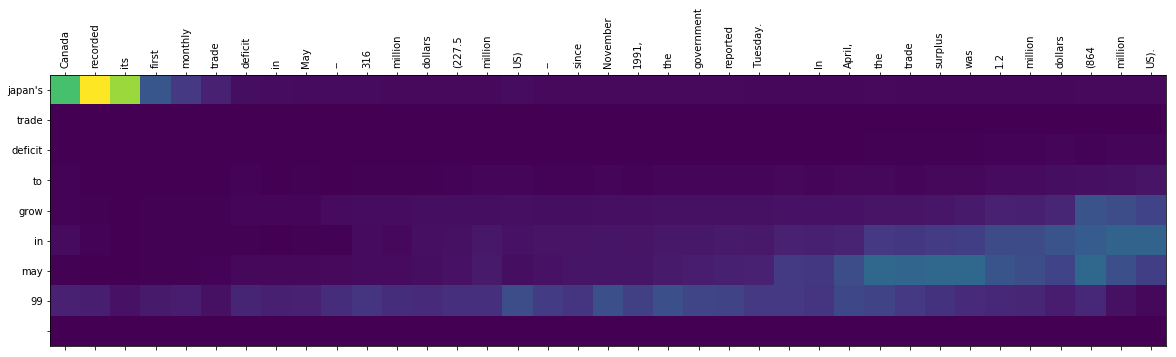

	 japan's trade deficit to grow in may 99 
The new president of the European Parliament, Klaus Haensch, of Germany, cast doubt Tuesday on the nomination of Jacques Santer as head of the European Commission, saying it was not "a given" the assembly would approve his nomination.  "A candidate chosen by heads of state and government who does not garner a majority in the European parliament will not have the necessary authority to create his commission and submit it for a vote of confidence by the parliament," Haensch told German radio.
00 Santer's confirmation not "a given": Haensch  99
GENERATED: 


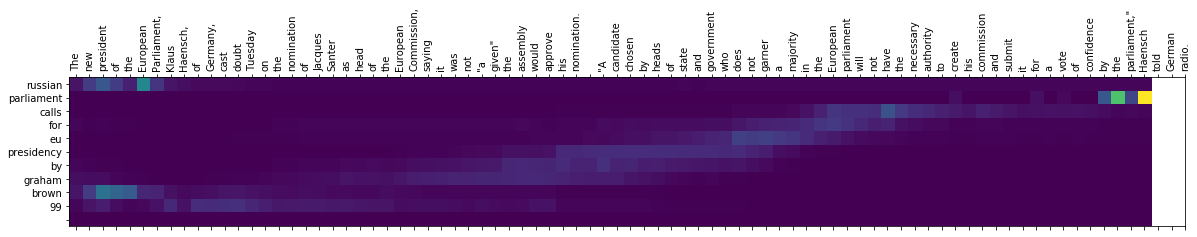

	 russian parliament calls for eu presidency by graham brown 99 


In [32]:
for i in range(20100,20120,3):
    print(val_df['story'][i])
    print(val_df['headline'][i])
    print('GENERATED: ')
    print('\t', headline(val_df['story'][i], encoder, decoder))
    print('='*10)